In [30]:
import pandas as pd
import jax.numpy as jnp
import numpyro
import numpy as np
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing

In [31]:
def add_date_range_with_cost(final_df, start_date, end_date, total_cost):
    
    date_range = pd.date_range(start=start_date, end=end_date)
    
    num_days = len(date_range)
    
    cost_per_day = total_cost / num_days
    
    new_dates_df = pd.DataFrame({
        'date': date_range,
        'cost': [cost_per_day] * num_days
    })
    
    updated_df = final_df.append(new_dates_df, ignore_index=True)
    
    updated_df['date'] = pd.to_datetime(updated_df['date'])
    updated_df.sort_values(by='date', inplace=True)
    
    updated_df = updated_df.groupby('date')['cost'].sum().reset_index()
    
    return updated_df

In [32]:
file_names = [
    'data tv - C8 Star +.csv',
    'data tv - M6.csv',
    'data tv - nrj12.csv',
    'data tv - tf1 2.csv',
    'data tv - TF1 Séries Films.csv',
    'data tv - tf1.csv',
    'data tv - tfx.csv',
    'data tv - tmc.csv',
    'data tv - tnt.csv',
    'data tv - W96ter Puissance TNT.csv'
]

dataframes = {f"df{i}": pd.read_csv(file_name) for i, file_name in enumerate(file_names, start=1)}

date_formats = '%d/%m/%Y'

for df_name, df in dataframes.items():
    df.dropna(axis=0, inplace=True)
    df['date'] = pd.to_datetime(df['date'], format= date_formats)
    
    df['cost'] = df.groupby('date')['cost'].transform('sum')
    df.drop_duplicates(subset='date', inplace=True)
    if df_name not in ['df6', 'df9']:
        df['cost'] = df['cost'] / 2
all_dfs_combined = pd.concat(dataframes.values(), ignore_index=True)

final_df = all_dfs_combined.groupby('date')['cost'].sum().reset_index()
final_df = add_date_range_with_cost(final_df, '2021-04-18', '2021-05-09', 132571)
final_df = add_date_range_with_cost(final_df, '2021-05-25', '2021-06-13', 98035)


C:\Users\Arij\AppData\Local\Temp\ipykernel_11120\1967173915.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = final_df.append(new_dates_df, ignore_index=True)
C:\Users\Arij\AppData\Local\Temp\ipykernel_11120\1967173915.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = final_df.append(new_dates_df, ignore_index=True)


In [33]:
final_df

,date,cost
0,2020-10-25,59408.250
1,2020-10-26,11863.800
2,2020-10-27,12707.600
3,2020-10-28,7258.800
4,2020-10-29,6281.600
...,...,...
214,2022-07-06,4578.460
215,2022-07-07,16193.785
216,2022-07-08,7665.535
217,2022-07-09,16673.240


In [34]:
ads_spend=pd.read_csv('data tv - ads spend.csv')
ads_spend['date']=pd.to_datetime(ads_spend['date'])

In [35]:
target_data=pd.read_csv('data tv - target.csv')
target_data['date']=pd.to_datetime(target_data['date'])

In [36]:
ads_spend['total_ads']=ads_spend['google']+ads_spend['meta']
ads_spend

,date,google,meta,total_ads
0,2020-01-01,991.81,0.0000,991.8100
1,2020-01-02,5742.32,0.0000,5742.3200
2,2020-01-03,5806.89,0.0000,5806.8900
3,2020-01-04,4881.33,0.0000,4881.3300
4,2020-01-05,5214.06,0.0000,5214.0600
...,...,...,...,...
1124,2022-12-27,6975.78,1503.6855,8479.4655
1125,2022-12-28,7543.94,1765.8900,9309.8300
1126,2022-12-29,7754.17,1755.6200,9509.7900
1127,2022-12-30,5096.50,1743.0700,6839.5700


In [37]:
final_df=final_df.merge(ads_spend[['date', 'google', 'meta','total_ads']], how='right', on='date')
final_df['cost'] = final_df['cost'].fillna(0)


In [38]:
final_df=final_df.merge(target_data, how='left', on='date')


In [39]:
final_df = final_df.rename(columns={'cost': 'tv cost'})


In [40]:
final_df

,date,tv cost,google,meta,total_ads,transactions,revenue
0,2020-01-01,0.0,991.81,0.0000,991.8100,86,31176.28
1,2020-01-02,0.0,5742.32,0.0000,5742.3200,168,57361.28
2,2020-01-03,0.0,5806.89,0.0000,5806.8900,154,60400.09
3,2020-01-04,0.0,4881.33,0.0000,4881.3300,107,38269.96
4,2020-01-05,0.0,5214.06,0.0000,5214.0600,145,47472.87
...,...,...,...,...,...,...,...
1124,2022-12-27,0.0,6975.78,1503.6855,8479.4655,456,191848.34
1125,2022-12-28,0.0,7543.94,1765.8900,9309.8300,522,212301.16
1126,2022-12-29,0.0,7754.17,1755.6200,9509.7900,428,197011.90
1127,2022-12-30,0.0,5096.50,1743.0700,6839.5700,405,161425.49


Lightweight MMM

In [41]:
mdsp_cols=['tv cost', 'google', 'meta']
SEED= 105
data_size = len(final_df)
n_media_channels = len(mdsp_cols)
media_data = final_df[mdsp_cols].to_numpy()
target = final_df['transactions'].to_numpy()
costs = final_df[mdsp_cols].sum().to_numpy()


In [42]:
test_data_period_size = 70
split_point = data_size - test_data_period_size
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
target_train = target[:split_point]
media_names=["tv", "google", "meta"]

In [43]:
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train = media_scaler.fit_transform(media_data_train)

target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)

In [44]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data=media_scaler.transform(media_data),
    target_data=target_scaler.transform(target),
    cost_data=costs)

In [45]:
correlations[0].style.background_gradient(cmap='RdBu', vmin=-1, vmax=1)


,feature_0,feature_1,feature_2,target
feature_0,1.000002,0.081696,-0.058886,0.166807
feature_1,0.081696,1.000000,0.460016,0.792467
feature_2,-0.058886,0.460016,1.000000,0.531206
target,0.166807,0.792467,0.531206,1.000000


In [46]:
mmm = lightweight_mmm.LightweightMMM(model_name="adstock")

In [47]:
number_warmup=2000
number_samples=2000

In [48]:
mmm.fit(
    media=media_data_train,
    media_prior=costs,
    target=target_train,
    number_warmup=number_warmup,
    number_samples=number_samples,
    media_names= media_names,
    degrees_seasonality=3,
    
    seed=SEED)

c:\Users\Arij\AppData\Local\Programs\Python\Python310\lib\site-packages\lightweight_mmm\lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 4000/4000 [23:57<00:00,  2.78it/s, 1023 steps of size 4.75e-04. acc. prob=1.00] 


In [49]:
mmm.print_summary()   



                            mean       std    median      5.0%     95.0%     n_eff     r_hat
         coef_media[0]      0.12      0.04      0.12      0.06      0.17      1.28      2.37
         coef_media[1]      0.66      0.03      0.66      0.61      0.71      1.88      1.50
         coef_media[2]      0.14      0.14      0.08      0.00      0.32      1.15      2.46
         coef_trend[0]     -0.00      0.00      0.00     -0.00      0.00      1.79      1.43
            expo_trend      0.81      0.23      0.81      0.50      1.18      1.48      2.14
           exponent[0]      0.88      0.09      0.88      0.74      1.00      1.71      1.59
           exponent[1]      0.99      0.01      1.00      0.99      1.00     42.93      1.05
           exponent[2]      0.93      0.08      0.96      0.79      1.00      6.46      1.36
gamma_seasonality[0,0]     -0.00      0.01     -0.00     -0.03      0.02     46.15      1.06
gamma_seasonality[0,1]      0.03      0.02      0.03      0.00      0

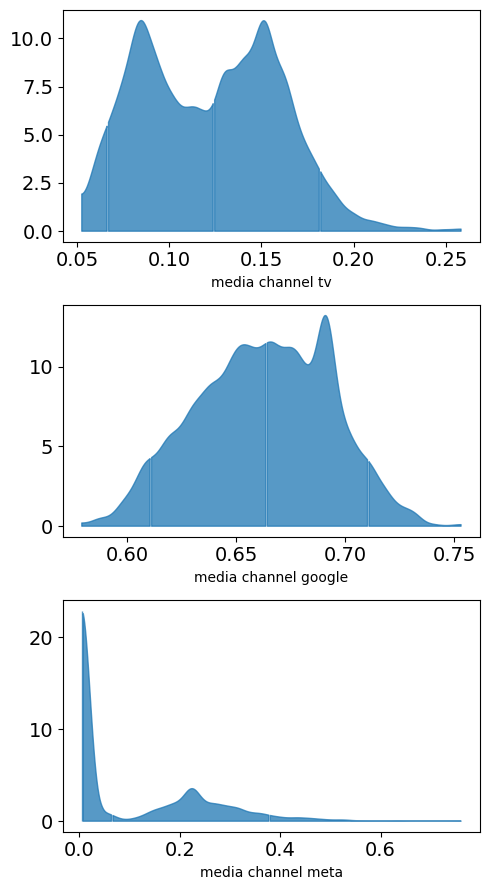

In [50]:
plot.plot_media_channel_posteriors(media_mix_model=mmm, channel_names=media_names )


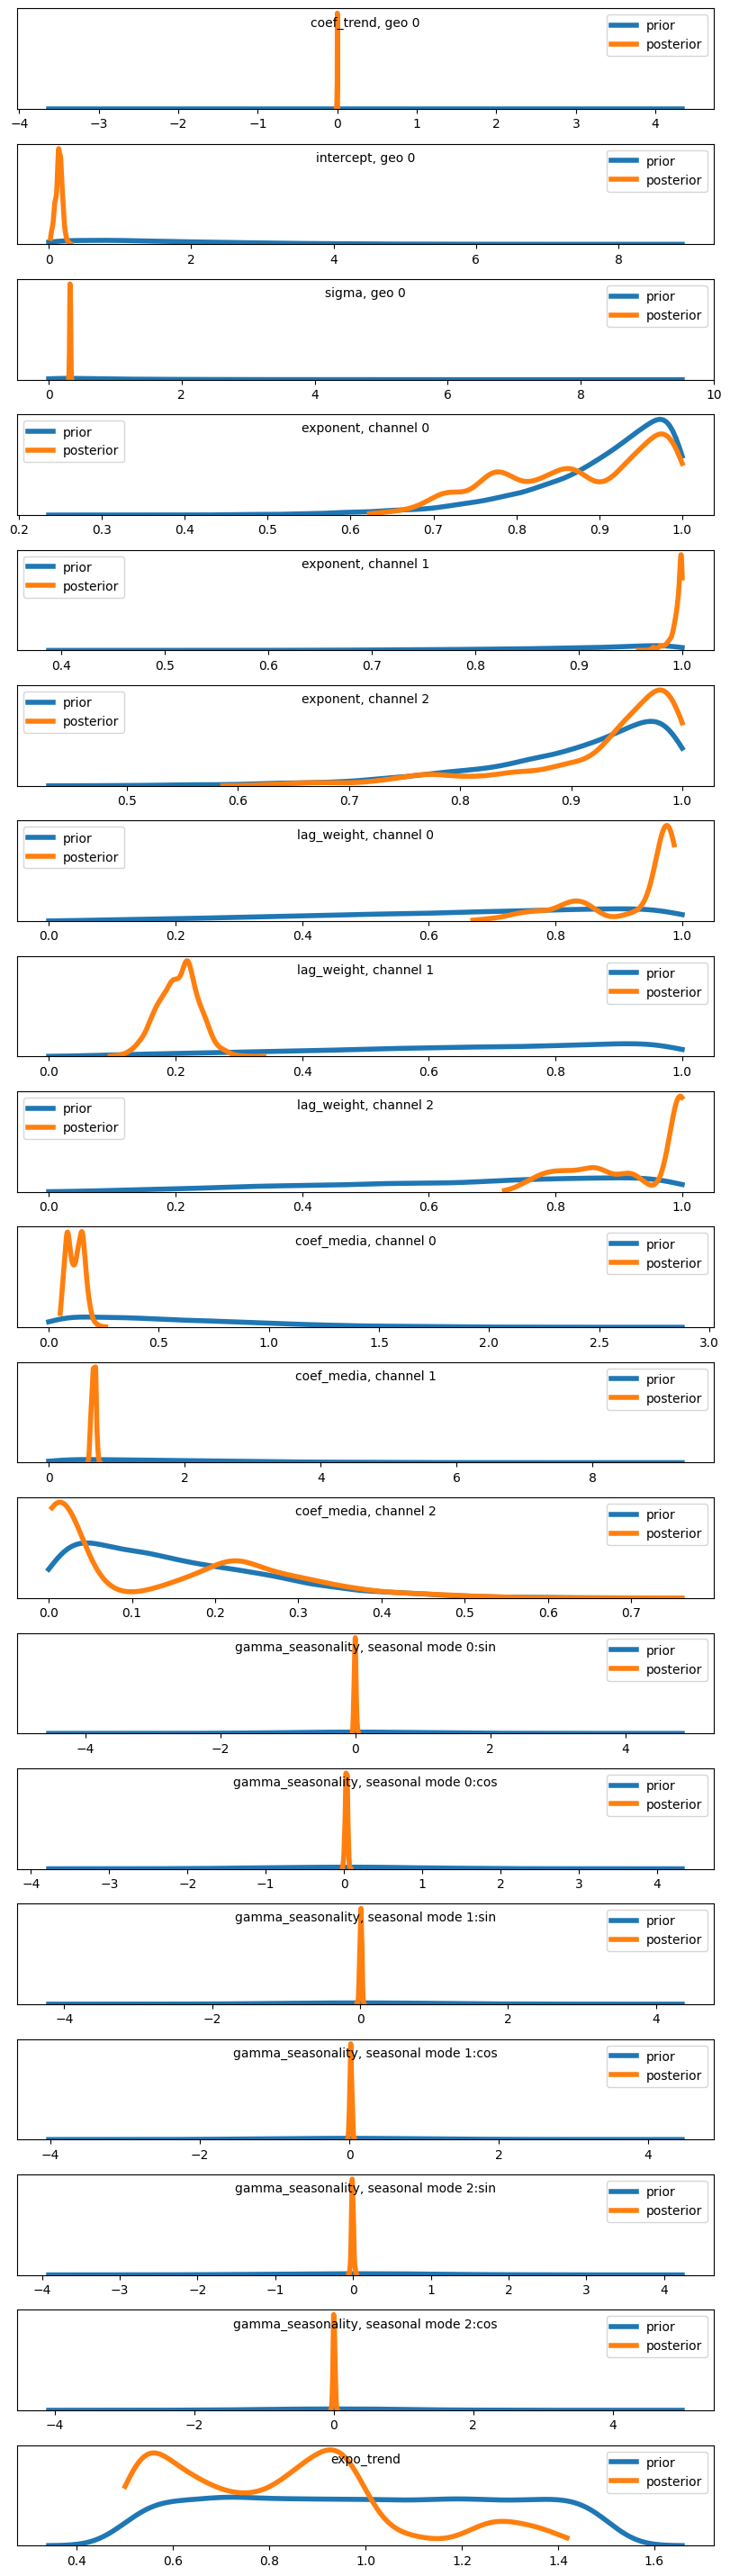

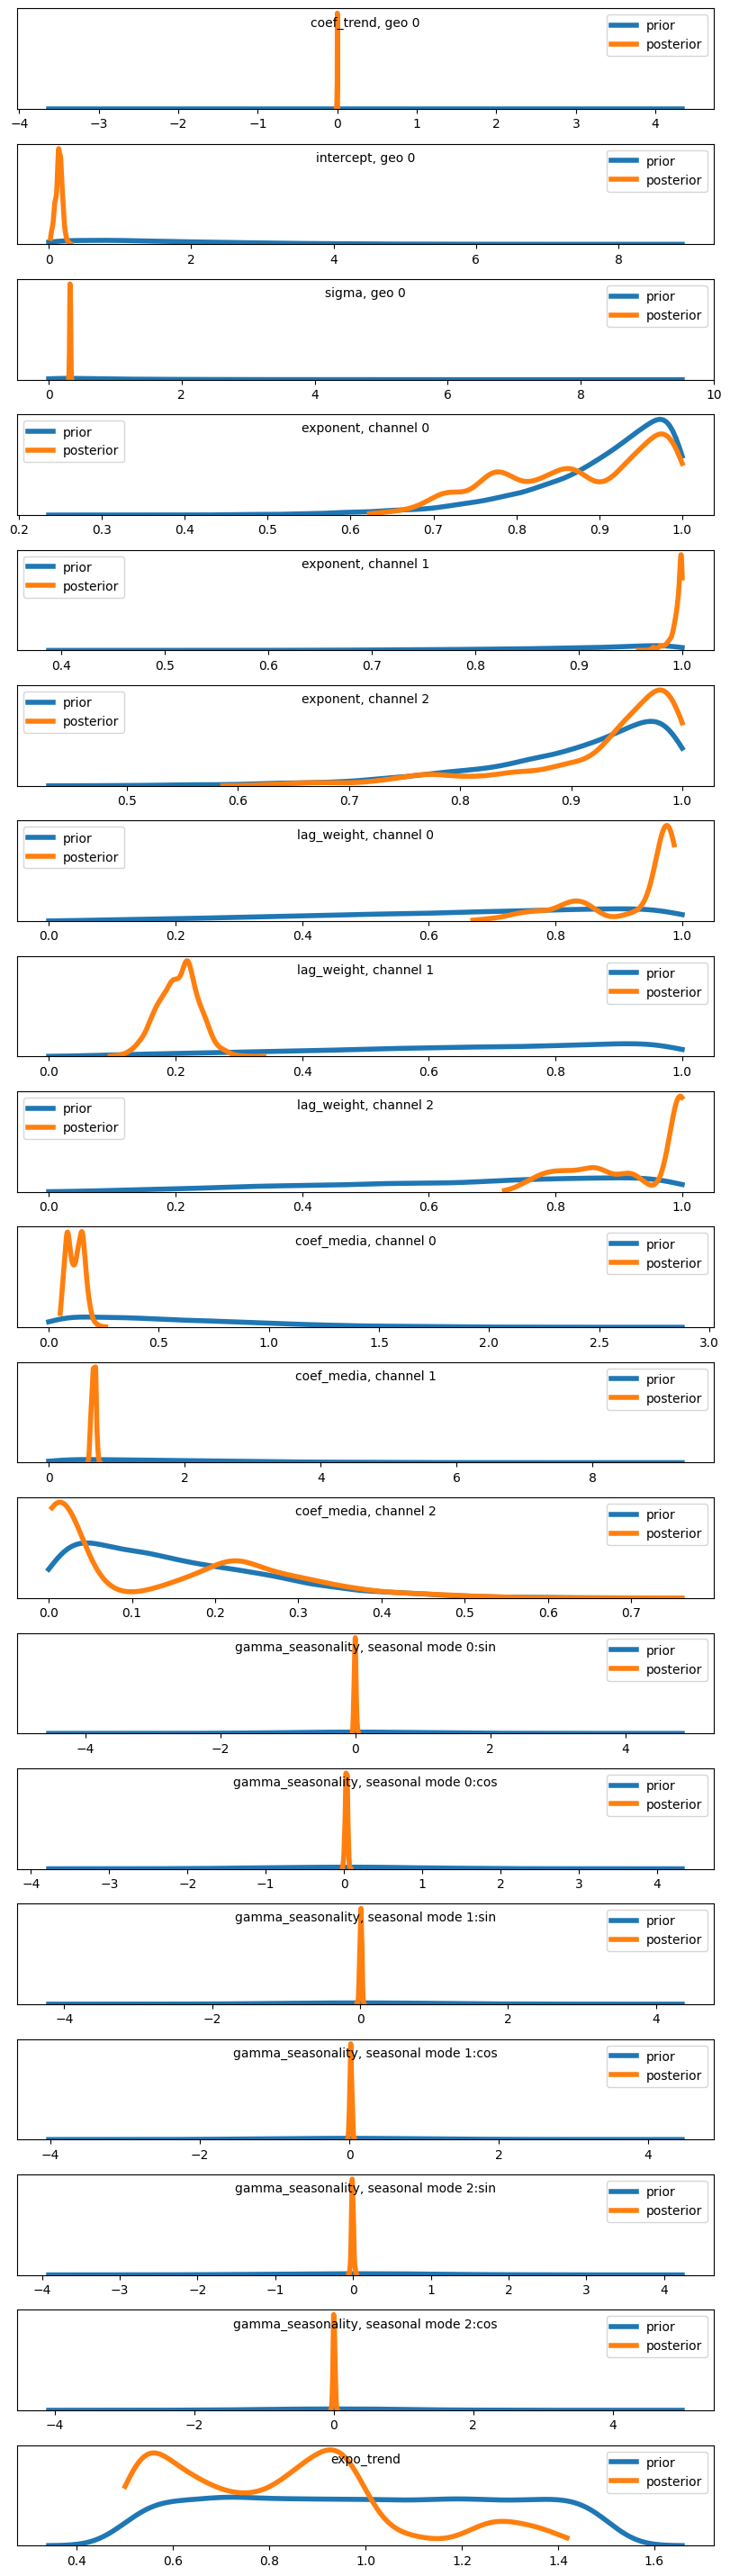

In [51]:
plot.plot_prior_and_posterior(media_mix_model=mmm)


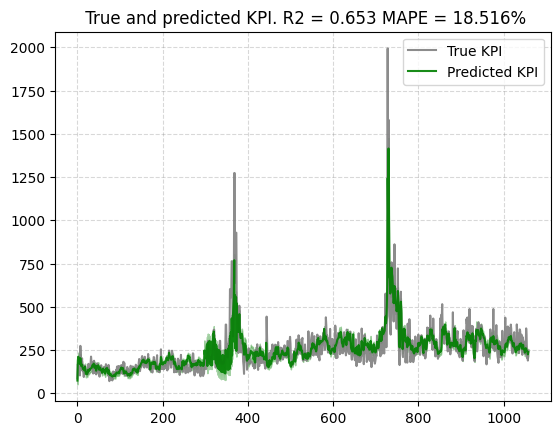

In [52]:
plot.plot_model_fit(mmm, target_scaler=target_scaler )


In [53]:
new_predictions = mmm.predict(media=media_scaler.transform(media_data_test), 
                              target_scaler=target_scaler,
                              seed=SEED)
new_predictions.shape

(4000, 70)

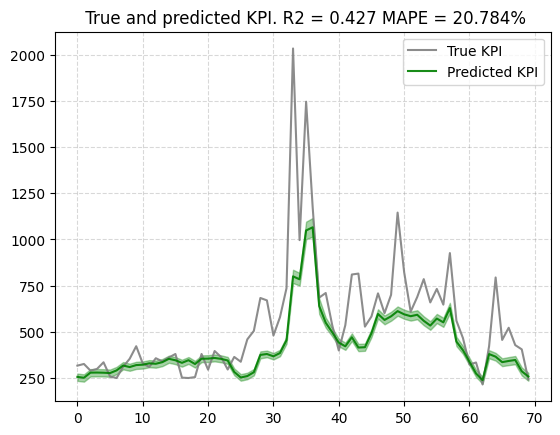

In [54]:
plot.plot_out_of_sample_model_fit(out_of_sample_predictions=new_predictions,
                                 out_of_sample_target=target[split_point:])

In [55]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)


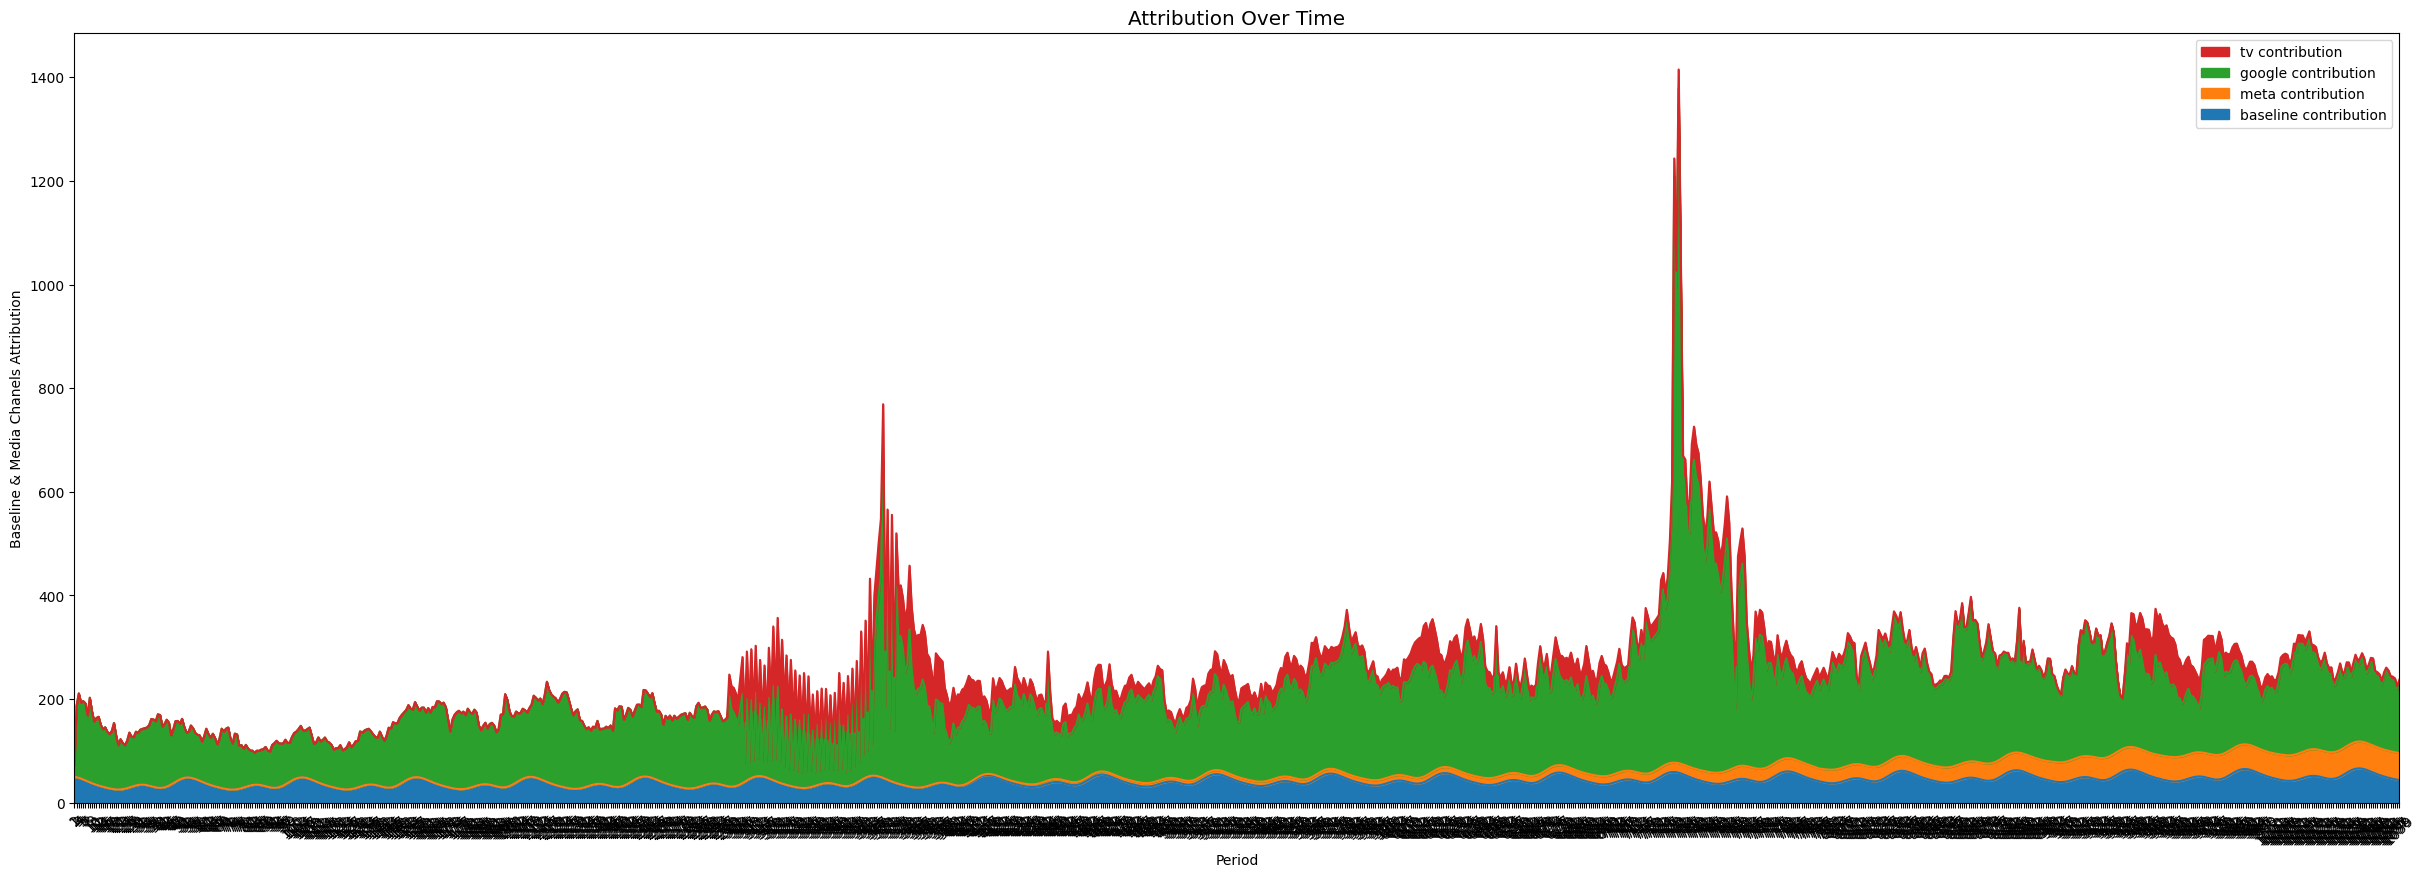

In [56]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model=mmm,
                                                target_scaler=target_scaler,
                                                fig_size=(30,10))

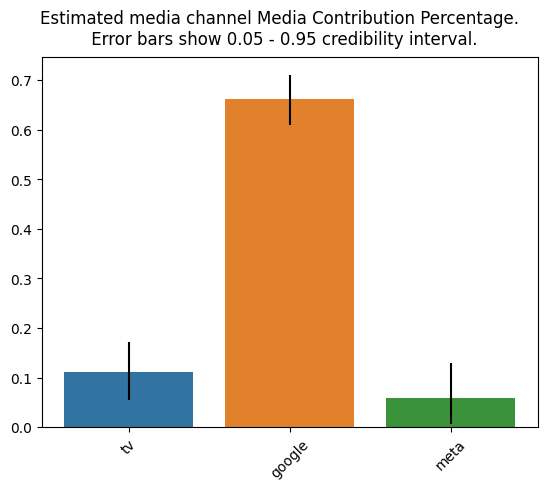

In [57]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", channel_names=media_names)


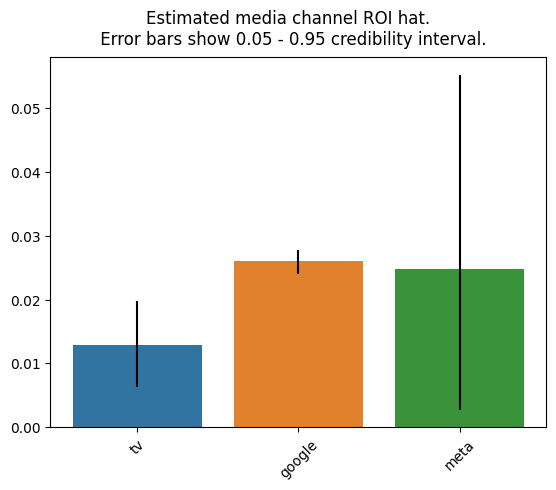

In [58]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names=media_names)
